In [1]:
import numpy as np
from numpy.random import random
import numba
import scipy.stats as st

In [5]:
import ot

In [2]:
seed = 1234
np.random.seed(seed)

particles = np.random.normal(0., 2., 500)
weights = np.random.chisquare(1.5, 500)
weights /= weights.sum()

In [3]:
def ess(w):
    return 1 / np.sum(np.square(w))

In [4]:
ess(weights)

173.68637608098658

In [7]:
# @numba.jit
def multinomial_resample(weights):
    # From filterpy
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors: ensures sum is exactly one
    return np.searchsorted(cumulative_sum, random(len(weights)))


In [285]:
# @numba.jit
def super_simple_filter(n_particles, noise_val, observation, seed, resample=True):
    np.random.seed(seed)
    log_lik = 0. #Doesn't matter where we start for this
    x_0 = np.random.normal(0., noise_val, n_particles)
    w_0 = np.full(n_particles, 1/n_particles)
    
    lik = st.norm.pdf(observation - x_0, 0., 1.)
    w_0_post = w_0 * lik
    log_lik += np.log(np.sum(w_0_post))
    
    w_1 = w_0_post / w_0_post.sum()
#     print(ess(w_1))
    if resample=='multi':
        index = multinomial_resample(w_1)
        w_1 = w_0[:]
        x_1 = x_0[index]
    elif resample=='none':
        x_1 = x_0[:]
    else:
        ot_matrix = ot.emd_1d(x_0, x_0, w_0, w_1)
        x_1 = ot_matrix @ x_1
        w_1 = w_0[:]
        
    x_2 = x_1 + np.random.normal(0., noise_val, x_1.shape)
    lik = st.norm.pdf(observation - x_2, 0., 1.)
    
    w_1_post = w_1 * lik
    log_lik += np.log(np.sum((w_1_post)))
    return log_lik

def super_simple_kalman(noise_val, observation):
    import pykalman
    kf = pykalman.KalmanFilter(transition_covariance=noise_val**2, observation_covariance=1., initial_state_covariance=noise_val ** 2)
    return kf.loglikelihood([observation, observation])

In [325]:
import matplotlib.pyplot as plt
linspace = np.linspace(1., 1.5, 50000)
ys = [super_simple_filter(10000, dx, 2., 4, 'multi') for dx in linspace]
ys_baseline = [super_simple_filter(10000, dx, 2., 4, 'none') for dx in linspace]
ys_kf = [super_simple_kalman(dx, 2.) for dx in linspace]


In [326]:
import seaborn
seaborn.set()

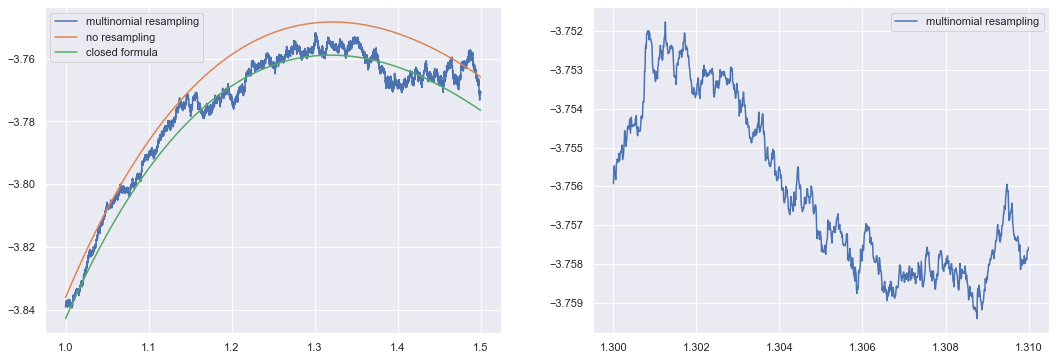

In [327]:
fig, axes = plt.subplots(ncols=2, figsize = (18, 6))
_ = axes[0].plot(linspace, ys, label = 'multinomial resampling')
_ = axes[0].plot(linspace, ys_baseline, label = 'no resampling')
_ = axes[0].plot(linspace, ys_kf, label = 'closed formula')
_ = axes[0].legend()
subset = slice(30000, 31000)

_ = axes[1].plot(linspace[subset], ys[subset], label = 'multinomial resampling')
_ = axes[1].legend()
# _ = ax.set_xlim(0.99, 1.01)
fig.savefig('resamplingDiscontinuity.png', layout='tight')

In [110]:
def test_ot(n, std, seed=42):
    np.random.seed(seed)
    x = np.random.normal(0., std, n)
    w = np.abs(np.random.normal(1., std, n))
    w /= w.sum()
    ones = np.full_like(w, 1/n)
    T = ot.emd_1d(x, x, w, ones).T
    y = ( n * T @ x )
    return y.mean()

In [111]:
linspace = np.linspace(0.5, 1., 1000)
ys = [test_ot(200, x) for x in linspace]

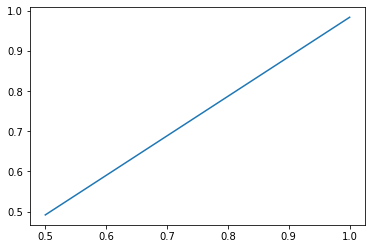

In [112]:
plt.plot(linspace, ys)

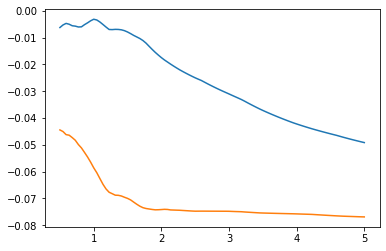

In [101]:
plt.plot(linspace, ys)